In [1]:
#hack till I make it a real package..
import os

#using GPU, comment out if on CPU?
os.environ['CUDA_DEVICE_ORDER'] = 'PCI_BUS_ID'
os.environ['CUDA_VISIBLE_DEVICES'] = '5'
import jax 
jax.config.update('jax_disable_jit', False)


In [2]:
import diffhydro as dh
from diffhydro.utils.io import athinput,athdf


In [3]:
#change to your sim location!
athena_outputs_loc = "/home/ben.horowitz/DiffHydro/tests/athena_ref_outputs/rt2d/"

ic_filename = "rt.out2.00000.athdf"

ICs = athdf(athena_outputs_loc+ic_filename)


In [4]:
ICs["mom2"].shape

(1, 200, 200)

In [5]:
#manually map from athena file to my format

import jax.numpy as jnp
sol = jnp.zeros((5,200,200))
sol = sol.at[0].set(ICs["dens"][0])
sol = sol.at[1].set(ICs["mom2"][0])
sol = sol.at[2].set(ICs["mom1"][0])
sol = sol.at[3].set(ICs["mom3"][0])
sol = sol.at[-1].set(ICs["Etot"][0])

2025-10-09 14:59:22.935869: W external/xla/xla/service/gpu/nvptx_compiler.cc:760] The NVIDIA driver's CUDA version is 12.1 which is older than the ptxas CUDA version (12.9.86). Because the driver is older than the ptxas version, XLA is disabling parallel compilation, which may slow down compilation. You should update your NVIDIA driver or use the NVIDIA-provided CUDA forward compatibility packages.
'+ptx89' is not a recognized feature for this target (ignoring feature)
'+ptx89' is not a recognized feature for this target (ignoring feature)
'+ptx89' is not a recognized feature for this target (ignoring feature)
'+ptx89' is not a recognized feature for this target (ignoring feature)
'+ptx89' is not a recognized feature for this target (ignoring feature)
'+ptx89' is not a recognized feature for this target (ignoring feature)
'+ptx89' is not a recognized feature for this target (ignoring feature)
'+ptx89' is not a recognized feature for this target (ignoring feature)
'+ptx89' is not a reco

In [58]:
class constant_force:
    def timestep(self,u):
        return 1E10
    def force(self,i,u,params,dt):
        print("updated_version")
        #hacked version...
        _,nc,_ = u.shape
        s_g = jnp.zeros((5, nc, nc))
        s_g = s_g.at[1].set(-0.1*u[0]) #momentum?
        s_g = s_g.at[2].set(0) #momentum?

       # grs = jnp.stack([gg[:,:,:,0],gg[:,:,:,1],gg[:,:,:,2]])
        s_g = s_g.at[-1].set(u[0]*0.1**2.0)
        return u+s_g*5E-2*dt


In [59]:
#custom boundary conditions

class reflection:
    def impose(self,sol,ax):
        if ax==1:
            sol = self.reflect_boundary(sol)
        else:
            sol = sol
        return sol

    def reflect_boundary(self,sol):
        #not really sure the best way to set these guys... probably should make it an input to the function

        sol = sol.at[:,0].set(sol[:,1]) #0,-1 is "ghost cell"
        sol = sol.at[:,-1].set(sol[:,-2])

        sol = sol.at[1,0].set(-sol[1,1])
        sol = sol.at[1,-1].set(-sol[1,-2])

        return sol

In [81]:
eq = dh.equationmanager.EquationManager()
#eq.box_size = (128.0, 256.0,1.0)
ss = dh.signal_speed_Rusanov
solver = dh.HLLC(equation_manager=eq,signal_speed=ss)
cf = dh.ConvectiveFlux(eq,solver,dh.MUSCL3(limiter="VANLEER"))
hydrosim = dh.hydro(n_super_step=5300,fluxes=[cf],splitting_schemes=[[2,1,1,2],[1,2,2,1]],boundary = reflection(),forces=[constant_force()])


'+ptx89' is not a recognized feature for this target (ignoring feature)
'+ptx89' is not a recognized feature for this target (ignoring feature)
'+ptx89' is not a recognized feature for this target (ignoring feature)


In [82]:

params = {}
q = hydrosim.evolve(sol,params)

Traced<ShapedArray(float32[5,200,200])>with<DynamicJaxprTrace(level=1/0)>
dt [Traced<ShapedArray(float32[])>with<DynamicJaxprTrace(level=1/0)>, 10000000000.0]
updated_version


'+ptx89' is not a recognized feature for this target (ignoring feature)
'+ptx89' is not a recognized feature for this target (ignoring feature)
'+ptx89' is not a recognized feature for this target (ignoring feature)


Populating the interactive namespace from numpy and matplotlib


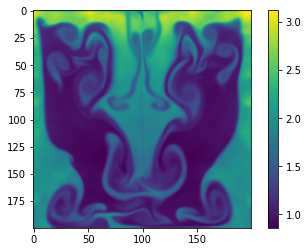

In [83]:
#looks bad
%pylab inline

imshow(q[0][0])
#imshow(hydrosim.outputs[-1][0][0][-1]-ICs["Etot"][0])#,vmin=-1E-4,vmax=1E-4)
colorbar()
show()

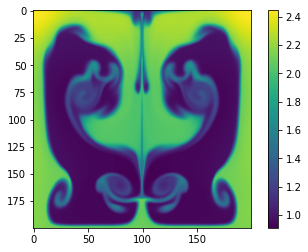

In [47]:
#not the exact matching timeslice, but close enough....
compare_filename = "rt.out2.10000.athdf" #only 6000 and 10000

t1s = athdf(athena_outputs_loc+compare_filename)

imshow(t1s["dens"][0])
colorbar()

In [12]:
#in practice the initialization locations are somewhat susceptable to numerical noise and/or solver method...
#for solver in loop, we start training a couple of timesteps in so we don't need to solver for that...